In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results"

print("--- Step 1: Load model and create simulator ---")
model_name = "gauss_gauss_1d_default"

model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

--- Step 1: Load model and create simulator ---
Model loaded: GaussGaussModel(mu0=0.0, sigma0=5.0, sigma=1.0)
📝 Created temporary observed data for prior sampling mode


In [12]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(123)
key, subkey_learn = jax.random.split(key)


regressor_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "regressor",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)
simulator.train_summary_network(subkey_learn, regressor_config)

--- Step 1.5 : Learn Summary Stats (Optional) ---
Updating model's summary statistics function...
Summary statistics learned and updated successfully!
   - Original data dimension: (10,)
   - Learned summary function integrated into model


TrainingResult(params={'params': {'output': {'bias': Array([-0.01637664], dtype=float32), 'kernel': Array([[-0.62025595],
       [-0.15515521],
       [ 0.21427226],
       [ 0.20098904],
       [-0.85522866],
       [-0.537767  ],
       [ 0.7126238 ],
       [-0.01313266],
       [-0.56702524],
       [-0.25586507],
       [ 0.8742666 ],
       [-0.6974215 ],
       [-0.515502  ],
       [ 0.6345514 ],
       [-0.4066254 ],
       [ 0.7431326 ]], dtype=float32)}, 'phi_dense_0': {'bias': Array([-0.19074082,  0.24657059,  0.09717306,  0.20300686,  0.05460005,
       -0.22622895, -0.21767351,  0.0556234 , -0.02787183,  0.19191828,
        0.1449787 ,  0.24785408, -0.16724962, -0.21950676, -0.305692  ,
       -0.19211137,  0.12618315, -0.22356416, -0.17223419,  0.13665245,
       -0.14542162, -0.16243312,  0.08381025,  0.24555442, -0.19826679,
       -0.15319273, -0.14615108,  0.26346418, -0.18503115, -0.22854288,
        0.24415804,  0.23055594], dtype=float32), 'kernel': Array([[ 0.363

In [ ]:
key, subkey_check = jax.random.split(key)
simulator.check_summary_stats_correlation(
    subkey_check,
    n_samples=10000)

--- Step 1.5 : Learn Summary Stats (Optional) ---
Updating model's summary statistics function...
📝 Created temporary observed data for prior sampling mode
Summary statistics learned and updated successfully!
   - Original data dimension: (10,)
   - Learned summary function integrated into model
Shapes : phi_samples: (10000, 1) x_samples: (10000, 10, 1)
Shapes: summary_stats: (10000, 1) phi_samples: (10000, 1)
Correlation between summary statistics and model parameters: [[0.99550855]]


Array([[0.99550855]], dtype=float32)

VERIFY THE CORRELATION (CAN BE COMPUTED)
TEST DRIVEN DEV from now on (SIMPLE TASK) SIMPLER TASK (CLASSIF REGRESSOR)
SUMMARY LEARNER -> REGRESSOR
FRIDAY RYAN TEST (MAKE HIS LIFE EASY AS POSSIBLE) --> 100D GAUSS TEST

In [3]:
#

key, key_sim = jax.random.split(key)


In [4]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

true_theta = 2.5
key, subkey_sample = jax.random.split(key)
x_obs = simulator.model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs: {x_obs}")

quantile_distance = 1.
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
🔄 Updated sampler with new observed data.
Observation x_obs: [[2.2519658]
 [1.5968924]
 [0.8846133]
 [1.6971498]
 [2.4508839]
 [2.3636103]
 [2.8143907]
 [0.727502 ]
 [3.7514272]
 [2.8580174]]


In [5]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

--- Step 2.2: Save model to YAML (Optional) ---


--- Step 2.3 : Load model from YAML and check (Optional) ---
Using provided epsilon = inf


Text(0.5, 0, 'Phi samples')

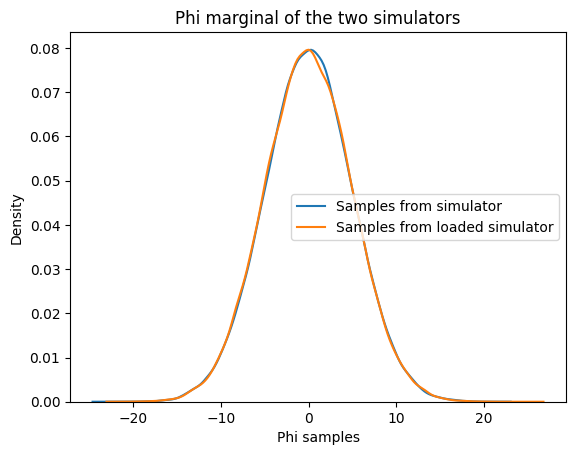

In [6]:
print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

key, key_samples, key_samples_load = jax.random.split(key, 3)
samples = simulator_loaded.generate_samples(key_samples, n_samples=100000)
samples_load = simulator_loaded.generate_samples(key_samples_load, n_samples=100000)

import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples.phi.flatten(), label="Samples from simulator"
            )
sns.kdeplot(samples_load.phi.flatten(), label="Samples from loaded simulator")
plt.legend()
plt.title("Phi marginal of the two simulators")
plt.xlabel("Phi samples")

In [7]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="mlp",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)


nn_config.training.num_epochs = 500
nn_config.training.batch_size = 1024
nn_config.training.n_samples_per_epoch = 10240
nn_config.training.learning_rate = 1e-2
nn_config.training.optimizer= "adamw"
nn_config.training.weight_decay = 1e-3

--- Step 3.1: Create NNConfig for training ---


In [8]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [9]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")

key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)

--- Step 3.3: Train the NeuralRatioEstimator ---
Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.15195581316947937
   - Total simulations: 195077


In [10]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---


--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
Using provided epsilon = inf


Text(0.5, 1.0, 'Phi marginal of the two estimators')

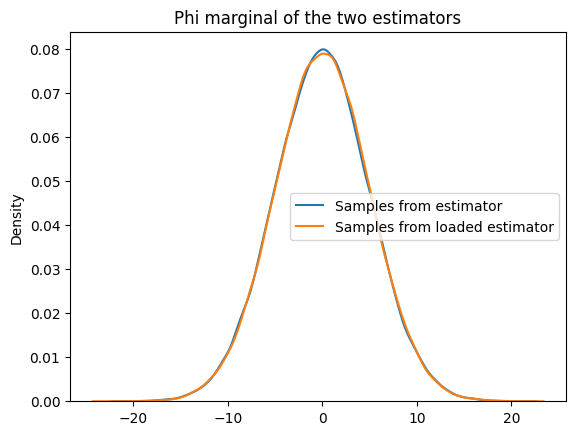

In [11]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

key, key_samples_estimator, key_samples_estimator_load = jax.random.split(key, 3)
samples_estimator = estimator.simulator.generate_samples(key_samples_estimator, n_samples=100000)
samples_estimator_load = estimator_loaded.simulator.generate_samples(key_samples_estimator_load, n_samples=100000)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples_estimator.phi.flatten(), label="Samples from estimator")
sns.kdeplot(samples_estimator_load.phi.flatten(), label="Samples from loaded estimator")
plt.legend()
plt.title("Phi marginal of the two estimators") 